In [26]:
# =========================================================================== #
# Library imports
# =========================================================================== #

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
import scipy.stats as stats
import emcee
import corner

import quantumsolver as qs


In [36]:
# =========================================================================== #
# Settings setup along with variable and general functions definitions
# =========================================================================== #

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(qs.fewnucleonEmulator)

# Define experimental/observed values of observables
y_E4He, sigma_E4He = -28.296, 0.005
y_Rp4He, sigma_Rp4He = 1.4552, 0.0062
y_E3H, sigma_E3H = -8.482, 0.015
y_fT3H, sigma_fT3H = 1129.6, 3.

def t_test(flat_samples):
    """
    Fit the samples to a t-distribution and print the parameters.

    Args:
        flat_samples (ndarray): The samples from the MCMC chain.
    """

    # Retrieve the samples
    cD_samples = flat_samples[:, 0]
    cE_samples = flat_samples[:, 1]
    # Fit the samples to a t-distribution
    df_cD, loc_cD, scale_cD = stats.t.fit(cD_samples)
    df_cE, loc_cE, scale_cE = stats.t.fit(cE_samples)
    # Print the result as a DataFrame
    data = {'df': [df_cD, df_cE], 'loc': [loc_cD, loc_cE], 'scale': [scale_cD, scale_cE]}
    print('t-distribution fit parameters:')
    df = pd.DataFrame(data, index=['cD', 'cE'])
    display(df)

def running_mean(x, factor):
    """ Return the running mean of N element in a list
    """
    it, walker = x.shape
    N = int(factor * it)
    average = np.zeros((it - N+1,walker))
    #print(average.shape)
    for i in range(walker):
        cumsum = np.cumsum(np.insert(x[:,i], 0, 0))
        #print((cumsum[N:] - cumsum[:-N]).shape)
        average[:,i] = ((cumsum[N:] - cumsum[:-N]) / float(N))
    average = np.sum(average,axis=1) / walker

    return average

def trace_plotter(sampler, iterations, sampler_idx=None, ndim=2, save=False):
    """
    Plot the traces of the MCMC chain.

    Args:
        sampler (emcee.EnsembleSampler): The sampler object,
        iterations (int): The number of iterations to plot,
        ndim (int): The number of dimensions of the parameter space.
    """
    

    # If we have three parameters (the extra task), plot the trace of Q as well
    if ndim == 3:
        fig_trace, ax_trace = plt.subplots(3, 1, sharex=True, figsize=(6, 6))
        ax_trace[2].plot([0,1,2], [0,1,2], 'k')
        ax_trace[2].plot(running_mean(sampler.chain[:, :iterations, 2].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)
        ax_trace[2].plot(sampler.chain[:, :iterations, 2].T, color='k', alpha=0.3)
        ax_trace[2].plot(running_mean(sampler.chain[:, :iterations, 2].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)
        ax_trace[2].set_ylabel(r'$Q$')
        ax_trace[2].legend(['Trace $Q$','Rolling average'],loc = 'upper right')
        ax_trace[2].set_xlabel('Sampler Iteration')
    # If we have two parameters, plot the traces of cD and cE
    else:
        fig_trace, ax_trace = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
        ax_trace[1].set_xlabel('Sampler Iteration')
    # Plot the traces of cD and cE
    ax_trace[0].plot([0,1,2], [0,1,2], 'k')
    ax_trace[0].plot(running_mean(sampler.chain[:, :iterations, 0].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)#, label='Rolling average')
    ax_trace[0].plot(sampler.chain[:, :iterations, 0].T, color='k', alpha=0.1)#, label='Traces $c_D$')
    ax_trace[0].plot(running_mean(sampler.chain[:, :iterations, 0].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)#, label='Rolling average')
    ax_trace[0].set_ylabel(r'$c_D$')
    ax_trace[1].plot([0,1,2], [0,1,2], 'k')
    ax_trace[1].plot(running_mean(sampler.chain[:, :iterations, 1].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)#, label='Rolling average')
    ax_trace[1].plot(sampler.chain[:, :iterations, 1].T, color='k', alpha=0.1)#, label='Traces $c_E$')
    ax_trace[1].plot(running_mean(sampler.chain[:, :iterations, 1].T,factor=0.015),color='tab:red',alpha=1,linewidth = 2)#, label='Rolling average')
    ax_trace[1].set_ylabel(r'$c_E$')
    ax_trace[0].legend(['Trace $c_D$','Rolling average'],loc = 'upper right')
    ax_trace[1].legend(['Trace $c_E$','Rolling average'],loc = 'upper right')

    if save:
        fig_trace.savefig('figs/post_samples_trace'+sampler_idx+'.pdf', bbox_inches='tight')

def contour_levels(grid, levels):
    """
    Compute contour levels for a 2D grid of pdf values.
    
    Args:
        grid (np.ndarray): 2D grid of pdf values,
        levels (list): list of confidence levels.
    
    Returns:
        np.ndarray: contour levels.
    """
    
    _sorted = np.sort(grid.ravel())[::-1]
    pct = np.cumsum(_sorted) / np.sum(_sorted)
    cutoffs = np.searchsorted(pct, np.array(levels) ** 2)

    return np.sort(_sorted[cutoffs])


In [15]:
# =========================================================================== #
# Task 1: Studies of the posterior with individual data likelihood
# =========================================================================== #

# ------- Bayesian functions used in task 1 (log_prior will be re-used) ----- #
def log_prior(params):

    # Unpack the parameters
    cD, cE = params[0], params[1]
    # Define the priors
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5

    return (stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma) + 
            stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma)) 

def log_ind_likelihood(params, data, y_i, sigma, efterror):
    
    # Unpack the parameters
    cD, cE = params[0], params[1]

    # If we are considering the error in the model 
    if efterror:
        sigma = np.sqrt(sigma**2 + (1 * 0.33**4 * y_i)**2/(1 - 0.33**2))

    return stats.norm.logpdf(y_i, loc=data, scale=sigma)

def log_ind_posterior(params, data, y_i, sigma, efterror):

    return log_prior(params) + log_ind_likelihood(params, data, y_i, sigma, efterror)


In [124]:
# ------- Evaluating the posterior for each individual data likelihood ------ #        

# Create a 2-dimensional grid
cD_grid = np.linspace(-2.5, 2.5, 3000)
cE_grid = np.linspace(-1., 1., 3000)
cD_eval, cE_eval = np.meshgrid(cD_grid, cE_grid)

# Calculate the theoretical values of the observables over the grid, these will be
# vectors of the same shape as cD_eval and cE_eval
E4He_eval, Rp4He_eval, _, _, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)

# Calculate the log posterior for each observable with the EFT error term
log_post_values_Rp4He = log_ind_posterior(np.array([cD_eval, cE_eval]), Rp4He_eval, y_Rp4He, sigma_Rp4He, True)
log_post_values_E3H = log_ind_posterior(np.array([cD_eval, cE_eval]), E3H_eval, y_E3H, sigma_E3H, True)
log_post_values_fT3H = log_ind_posterior(np.array([cD_eval, cE_eval]), fT3H_eval, y_fT3H, sigma_fT3H, True)
log_post_values_E4He = log_ind_posterior(np.array([cD_eval, cE_eval]), E4He_eval, y_E4He, sigma_E4He, True)

# Calculate the log posterior for each observable without the EFT error term
log_post_values_Rp4He_no_error = log_ind_posterior(np.array([cD_eval, cE_eval]), Rp4He_eval, y_Rp4He, sigma_Rp4He, False)
log_post_values_E3H_no_error = log_ind_posterior(np.array([cD_eval, cE_eval]), E3H_eval, y_E3H, sigma_E3H, False)
log_post_values_fT3H_no_error = log_ind_posterior(np.array([cD_eval, cE_eval]), fT3H_eval, y_fT3H, sigma_fT3H, False)
log_post_values_E4He_no_error = log_ind_posterior(np.array([cD_eval, cE_eval]), E4He_eval, y_E4He, sigma_E4He, False)

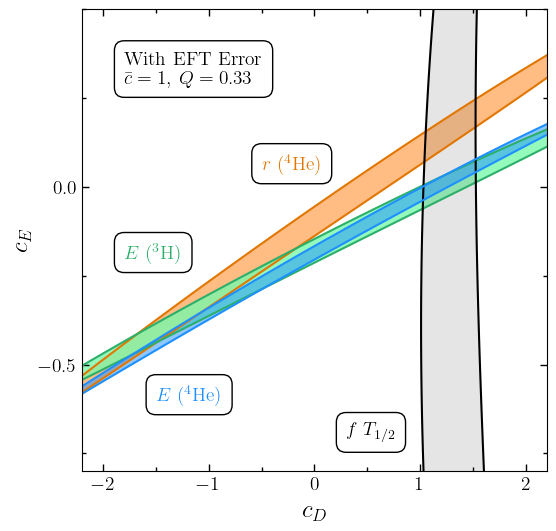

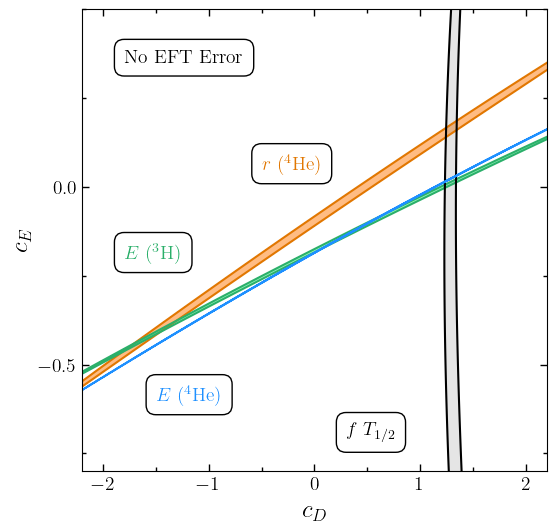

In [126]:
# - Functions for visualizing the posterior with individual data likelihood - #              
def post_plot(ax, colors, alpha, colors_contour, log_post_values):
    """
    Plot the posterior as a filled contour plot along with the contour lines
    constraining the parameters cD and cE in a 68% confidence region given
    by the contour_levels function.
    
    Args:
        ax (matplotlib.axes.Axes): Axes object for the plot,
        colors (str): Color for the filled contour plot,
        alpha (float): Transparency level for the filled contour plot,
        colors_contour (str): Color for the contour lines,
        log_post_values (np.ndarray): Log posterior values on the grid.
    """

    # Compute the posterior values
    post_values = np.exp(log_post_values)

    # Retrieve the contour levels
    levels = contour_levels(post_values, [np.sqrt(0.39)])
    # Define the levels, so we plot between the 68-level and the maximum to
    # visualize the constraints
    levels = [levels[0], np.max(post_values)]

    # Plot the posterior as a filled contour plot along with the contour lines
    contour_lines = ax.contourf(cD_grid, cE_grid, post_values, levels=levels, colors=colors, alpha=alpha)
    ax.contour(contour_lines, colors=colors_contour)

def customizer(ax, efterror=False, save=False):
    """
    Customize the plot by adding labels, legends and text.

    Args:
        ax (matplotlib.axes.Axes): Axes object for the plot,
        efterror (bool): Whether the EFT error is considered or not,
        save (bool): Whether to save the plot or not.
    """

    # Remove any text from the plot before adding new text
    for txt in ax.texts[1:]:
        txt.set_visible(False)
        ax.texts[1:].remove(txt)

    # Labels
    ax.set_xlabel('$c_D$', fontsize=font_size+4)
    ax.set_ylabel('$c_E$', fontsize=font_size+4)
    # Text labels for the observables
    ax.text(0.3, -0.7, '$f$ $T_{1/2}$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-0.5, 0.05, '$r$ ($^4$He)', color='#e17701', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-1.8, -0.2, '$E$ ($^3$H)', color='#2baf6a', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-1.5, -0.6, '$E$ ($^4$He)', color='dodgerblue', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    # Set the font size for the ticks
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_ylim(-0.8, 0.5)
    ax.set_xlim(-2.2, 2.2)
    ax.set_yticks([-0.5, 0.])
    ax.set_xticks([-2., -1, 0., 1, 2.])
    
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=3, width=1, colors='black')

    # Add the error legend depending on if the error is considered or not
    if efterror:
        ax.text(-1.8, 0.29, 'With EFT Error \n $\\bar{c}=1$, $Q=0.33$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    else:
        ax.text(-1.8, 0.35, 'No EFT Error', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    
    # Save the plot if save is True
    fig = ax.get_figure()
    if efterror and save:
        fig.savefig('figs/constraints_EFT_exp_new.pdf', bbox_inches='tight')
    elif save:
        fig.savefig('figs/constraints_noEFT_exp_new.pdf', bbox_inches='tight')

# Plot the posterior with individual data likelihood with error
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
post_plot(ax1, colors='#ffb16d', alpha=0.85, colors_contour='#e17701', log_post_values=log_post_values_Rp4He)
post_plot(ax1, colors='#7af9ab', alpha=0.8, colors_contour='#2baf6a', log_post_values=log_post_values_E3H)
post_plot(ax1, colors='gray', alpha=0.2, colors_contour='black', log_post_values=log_post_values_fT3H)
post_plot(ax1, colors='dodgerblue', alpha=0.5, colors_contour='dodgerblue', log_post_values=log_post_values_E4He)

# Plot the posterior with individual data likelihood without error
fig2, ax2 = plt.subplots(1, 1, figsize=(6, 6))
post_plot(ax2, colors='#ffb16d', alpha=0.85, colors_contour='#e17701', log_post_values=log_post_values_Rp4He_no_error)
post_plot(ax2, colors='#7af9ab', alpha=0.8, colors_contour='#2baf6a', log_post_values=log_post_values_E3H_no_error)
post_plot(ax2, colors='gray', alpha=0.2, colors_contour='black', log_post_values=log_post_values_fT3H_no_error)
post_plot(ax2, colors='dodgerblue', alpha=0.5, colors_contour='dodgerblue', log_post_values=log_post_values_E4He_no_error)

# Customizing the plots
customizer(ax1, efterror=True, save=False)
customizer(ax2, efterror=False, save=False)


In [16]:
# =========================================================================== #
# Task 2: Sample the posterior
# =========================================================================== #         

# ------------------- Bayesian functions used in task 2 --------------------- #
def log_likelihood(params, data_set):
    """
    Calculate the log likelihood for the given data set.

    Args:
        params (np.ndarray): Array of parameters. In the case of MCMC sampling,
                             this is a 2D array with shape (2,),
        data_set (tuple): Tuple of strings representing the data set.
    
    Returns:
        float: The log likelihood value for the total data set.
    """

    # Unpack the parameters
    cD, cE = params[0], params[1]
    # Calculate the theoretical values of the observables
    E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

    # Calculate the EFT error term
    sigma_EFT_E3H = np.sqrt(sigma_E3H**2 + (1 * 0.33**4 * y_E3H)**2/(1 - 0.33**2))
    sigma_EFT_E4He = np.sqrt(sigma_E4He**2 + (1 * 0.33**4 * y_E4He)**2/(1 - 0.33**2))
    sigma_EFT_Rp4He = np.sqrt(sigma_Rp4He**2 + (1 * 0.33**4 * y_Rp4He)**2/(1 - 0.33**2))
    sigma_EFT_fT3H = np.sqrt(sigma_fT3H**2 + (1 * 0.33**4 * y_fT3H)**2/(1 - 0.33**2))

    # Calculate and return the likelihood for the case with two observables
    if len(data_set) == 2:
        return (stats.norm.logpdf(y_E4He, E4He, sigma_EFT_E4He) + 
                stats.norm.logpdf(1.4552, Rp4He, sigma_EFT_Rp4He))
    # Calculate and return the likelihood for the case with four observables
    elif len(data_set) == 4:
        return (stats.norm.logpdf(y_E4He, E4He, sigma_EFT_E4He) +
                stats.norm.logpdf(1.4552, Rp4He, sigma_EFT_Rp4He) +
                stats.norm.logpdf(-8.482, E3H, sigma_EFT_E3H) +
                stats.norm.logpdf(1129.6, fT3H, sigma_EFT_fT3H))

def log_posterior(params, data_set):
    """
    Calculate the log posterior for the given data set.

    Args:
        params (np.ndarray): Array of parameters. In the case of MCMC sampling,
                             this is a 2D array with shape (2,),
        data_set (tuple): Tuple of strings representing the data set.
    
    Returns:
        float: The log posterior value for the total data set.
    """
    
    return log_prior(params) + log_likelihood(params, data_set)

# Initial position for the walkers
cD = np.random.normal(0., 1, 25)
cE = np.random.normal(0., 1, 25)

# Create a 2D array of the initial positions and retrieve the number 
# of walkers and dimensions
pos = np.vstack((cD, cE))
nwalkers, ndim = pos.T.shape

# The case considering the data set with two observables
sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=[('E4He', 'Rp4He')])
run_2 = sampler_2.run_mcmc(pos.T, 50500, progress=True)

# The case considering the data set with four observables
#sampler_4 = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=[('E4He', 'Rp4He', 'E3H', 'fT3H')])
#run_4 = sampler_4.run_mcmc(pos.T, 50500, progress=True)

100%|██████████| 50500/50500 [06:42<00:00, 125.52it/s]


Number of samples:  1250000


,Mean,Sigma
cD,-1.616565,2.260569
cE,-0.479994,0.410142


t-distribution fit parameters:


,df,loc,scale
cD,2.650385e+01,-1.639717,2.173191
cE,8.301505e+09,-0.479994,0.410142


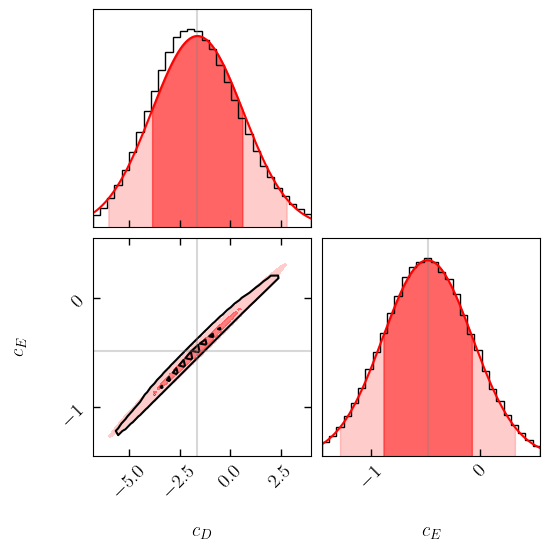

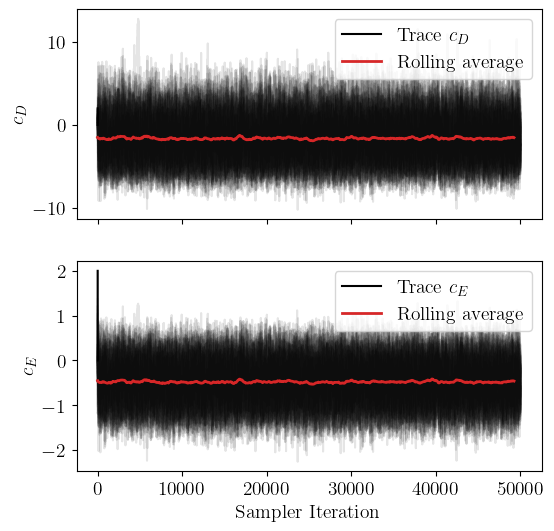

In [17]:
# ---------------------- Analysis of the MCMC samples ----------------------- #         
def sample_analyzer(sampler, save=False):
    """
    Analyze the MCMC samples by fitting a multivariate normal distribution and
    plotting the corner plot with the 1 and 2-sigma contours, the trace plots
    and the normal-distribution fit for each parameter.

    Args:
        sampler (emcee.EnsembleSampler): The MCMC sampler object.

    Returns:
        np.ndarray: The flattened samples from the MCMC chain.
    """
    
    def fit_samples(flat_samples):
        """
        Fit a multivariate normal distribution to the MCMC samples.

        Args:
            flat_samples (np.ndarray): The flattened samples from the MCMC chain.
        
        Returns:
            stats.multivariate_normal: The fitted multivariate normal distribution,
            float: The mean for cD of the fitted MV-distribution,
            float: The mean for cE of the fitted MV-distribution,
            float: The standard deviation for cD of the fitted MV-distribution,
            float: The standard deviation for cE of the fitted MV-distribution.
        """

        # Fit a multivariate normal distribution to the samples
        mv_fit = stats.multivariate_normal.fit(flat_samples)
        # Means of the fit
        mv_means = mv_fit[0]
        # Covariance matrix of the fit
        mv_cov = mv_fit[1]
        # Means and sigmas for cD and cE
        mu_cD, mu_cE  = mv_means[0], mv_means[1]
        sigma_cD, sigma_cE = np.sqrt(mv_cov[0, 0]), np.sqrt(mv_cov[1, 1])

        # A frozen multivariate normal distribution object
        mv_pdf = stats.multivariate_normal(mean=mv_means, cov=mv_cov)

        return mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE

    def corner_contourf(contour_ax, mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE):
        """
        Plot the contours of the fitted multivariate normal distribution in the
        corner plot and fill the 68% and 95% credible regions.

        Args:
            contour_ax (matplotlib.axes.Axes): Axes object for the plot,
            mv_pdf (stats.multivariate_normal): The fitted multivariate normal distribution,
            mu_cD (float): The mean for cD of the fitted MV-distribution,
            mu_cE (float): The mean for cE of the fitted MV-distribution,
            sigma_cD (float): The standard deviation for cD of the fitted MV-distribution,
            sigma_cE (float): The standard deviation for cE of the fitted MV-distribution.
        
        Returns:
            list: The x-ticks for cD,
            list: The x-ticks for cE,
            tuple: The x-limits for the plot.
        """

        # Define a grid for evaluating the MV-distribution
        x = np.linspace(-20, 20, 1000)
        y = np.linspace(-20, 20, 1000)
        x_eval, y_eval = np.meshgrid(x, y)
        pos = np.dstack((x_eval, y_eval))

        # Evaluate the MV-distribution on the grid
        pdf_values = mv_pdf.pdf(pos)

        # Maximum value of the MV-distribution
        mv_pdf_max = np.max(mv_pdf.pdf(pos))
        # Compute the 68 % and 95 % cutoffs and add the maximum value to the levels
        levels = contour_levels(pdf_values, np.sqrt([0.39, 0.86]))
        levels = np.hstack((levels, [mv_pdf_max]))
        # Plot the filled contour plot
        contourf_plot = contour_ax.contourf(x, y, mv_pdf.pdf(pos), levels=levels, 
                                    colors=['r', 'r'], alpha=[0.2, 0.5])
        #contour_ax.contour(x, y, mv_pdf.pdf(pos), levels=[pdf_95, pdf_68], colors='k')

        # Set the x-ticks and limits for the contour plot (also used for the
        # histograms in the corner plot)

        if sampler_idx == '4':
            xticks_cD, xticks_cE = [0.25, 1.25, 2.25], [-0.1, 0.05, 0.2]
            contour_ax.set_xlim(-0.2, 2.5)
            contour_ax.set_ylim(-0.22, 0.25)
       
        if sampler_idx == '2':
            xticks_cD, xticks_cE = [-5,-2.5, 0,2.5], [-1, 0.]
            contour_ax.set_xlim(-6.8, 4)
            contour_ax.set_ylim(-1.45,0.55)

        contour_ax.set_xticks(xticks_cD)
        contour_ax.set_yticks(xticks_cE)
        contour_ax.yaxis.set_ticks_position('both')
        contour_ax.xaxis.set_ticks_position('both')
        contour_ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')

        # Add vertical and horizontal lines at the mean values
        contour_ax.axvline(mu_cD, color='gray', linestyle='-', alpha=0.3)
        contour_ax.axhline(mu_cE, color='gray', linestyle='-', alpha=0.3)

        return xticks_cD, xticks_cE, contour_ax.get_xlim()

    def plot_fit(ax, samples, mu, sigma):
        """
        Plot the multivariate normal-distribution fit over the histogram of 
        the samples.

        Args:
            ax (matplotlib.axes.Axes): Axes object for the plot,
            samples (np.ndarray): The cD/cE samples from the MCMC chain,
            mu (float): The mean for cD/cE of the fitted MV-distribution,
            sigma (float): The standard deviation for cD/cE of the fitted 
                            MV-distribution.
        """
        
        def fill(cred_region, alpha):
            """
            Fill the region of the distribution PDF that corresponds to the
            given credible region.

            Args:
                cred_region (float): The credible region to be filled,
                alpha (float): Transparency level for the filled region.
            """

            # Calculate the lower and upper bounds of the credible region
            lower = stats.norm.ppf(1-(1+cred_region)/2, mu, sigma)
            upper = stats.norm.ppf((1+cred_region)/2, mu, sigma)
            # Fill between the lower and upper bounds
            ax.fill_between(x, norm_pdf, where=((x >= lower) & (x <= upper)), 
                        color='r', alpha=alpha)

        # Each 'poly' is a Polygon object; we can extract the vertices
        verts = ax.patches[0].get_xy()

        # The x-values represent the bin edges, y-values represent the heights
        bin_left_edges = verts[:, 0]
        bin_heights = verts[:, 1]
        # Calculate the bin width
        bin_width = np.diff(bin_left_edges)[1]

        # Total histogram area
        area = np.sum(bin_width/2 * bin_heights)

        # Generate the normal-distribution PDF using the fitted parameters
        x = np.linspace(samples.min(), samples.max(), 1000)
        # Values for the normal-distribution PDF
        norm_pdf = stats.norm.pdf(x, loc=mu, scale=sigma) * area

        # Plot the normal-distribution PDF over the histogram
        ax.axvline(mu, color='gray', linestyle='-', alpha=0.3)
        ax.plot(x, norm_pdf, 'r')
        
        # Fill the 68 % and 95 % credible regions
        fill(0.95, 0.2)
        fill(0.68, 0.5)

    if sampler == '2':
        sampler = sampler_2
        ranges = [(-6.8, 4), (-1.45, 0.55)]
        sampler_idx = '2'
    elif sampler == '4':
        sampler = sampler_4
        sampler_idx = '4'
        ranges = [(-0.2, 2.5), (-0.22, 0.25)]

    # Retrieve the samples from the MCMC chain
    flat_samples = sampler.get_chain(discard=500, thin=1, flat=True)
    print('Number of samples: ', flat_samples.shape[0])
    # Plot the corner plot with the 1 and 2-sigma contours
    fig = corner.corner(flat_samples, labels=[r"$c_D$", r"$c_E$"], color='k',
                    show_titles=False, bins=30, plot_contours=True, plot_datapoints=False, 
                    plot_density=False, levels=[0.39, 0.86], range=ranges)
    fig.set_size_inches(6, 6)

    # Fit a multivariate normal distribution to the samples
    mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE = fit_samples(flat_samples)

    # Dataframe for the fitted parameters
    data = {'Mean': [mu_cD, mu_cE], 'Sigma': [sigma_cD, sigma_cE]}
    df = pd.DataFrame(data, index=['cD', 'cE'])
    display(df)

    # Plot the contours of the fitted multivariate normal distribution in the
    # corner plot and fill the 68% and 95% credible regions
    contour_ax = fig.get_axes()[2]
    # The corner_contourf function returns the x-ticks for cD and cE and the
    # x-limits used later
    x_ticks_cD, x_ticks_cE, xlim = corner_contourf(contour_ax, mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE)

    # Plot the normal-distribution fit for each parameter in the corner plot
    for i, ax in enumerate(fig.get_axes()):
        ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
        if i == 0:
            # Set the x-ticks and limits for cD
            ax.set_xticks(x_ticks_cD)
            ax.set_xlim(xlim[0], xlim[1])
            plot_fit(ax, flat_samples[:, 0], mu_cD, sigma_cD)
        elif i == 3:
            # Set the x-ticks for cE
            ax.set_xticks(x_ticks_cE)
            plot_fit(ax, flat_samples[:, 1], mu_cE, sigma_cE)

    # Plot the trace plots for each parameter
    trace_plotter(sampler, iterations=50000, sampler_idx=sampler_idx, save=False)
    # Test how well the samples are fitted by a t-distribution
    t_test(flat_samples)
    
    if save:
        fig.savefig('figs/post_sampling'+sampler_idx+'.pdf', bbox_inches='tight')
        
    plt.show()

    return flat_samples

samples_2 = sample_analyzer(sampler='2',save=False)
#samples_4 = sample_analyzer(sampler='4',save=False)

,Mean,Sigma
E3H,-8.525772,0.053197
E4He,-28.425038,0.288486
Rp4He,1.484894,0.007368
fT3H,1133.723110,14.150774


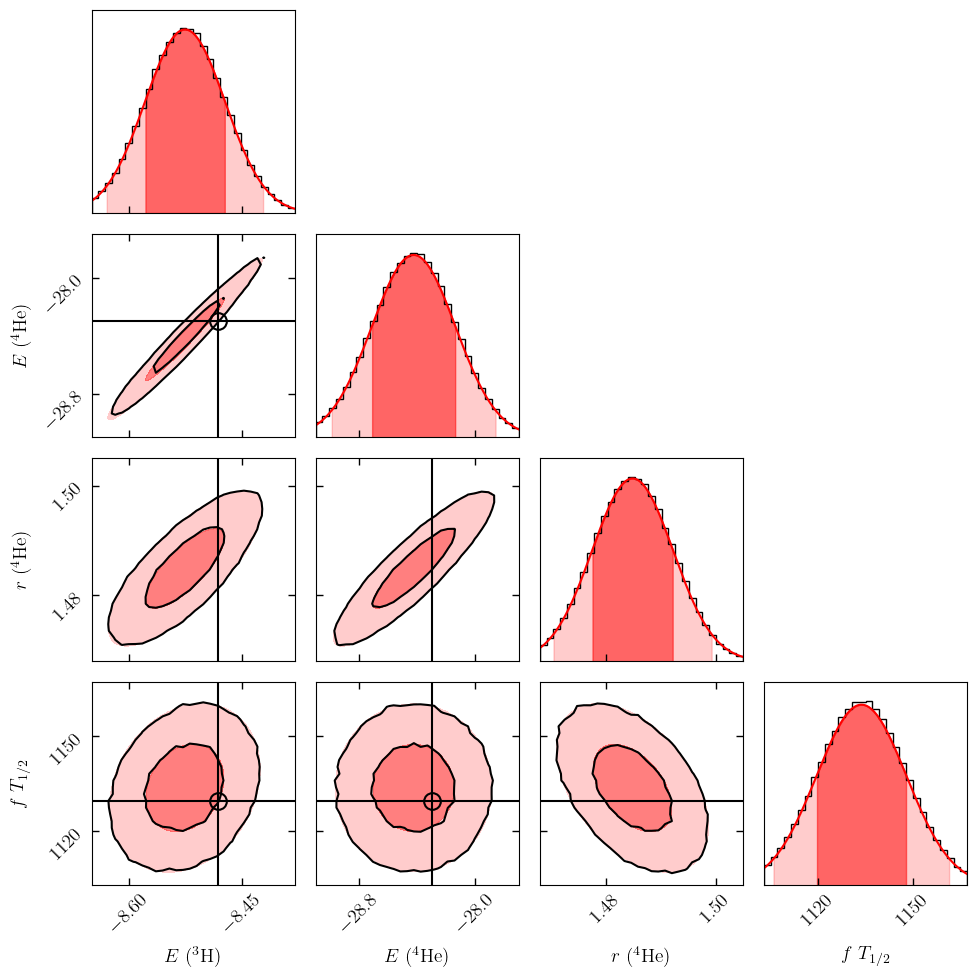

In [10]:
# =========================================================================== #         
# Task 3: Posterior predictive distributions
# =========================================================================== #

# -------- Functions used to visualize the predictive distributions --------- #
def fit_samples(preds):
    """
    Fit a multivariate normal distribution to the predictive distributions
    of the observables.

    Args:
        preds (np.ndarray): The predictive distributions for the observables,
                            array with four columns (one for each observable).
    
    Returns:
        tuple: The means of the fitted MV-distribution,
        np.ndarray: The covariance matrix of the fitted MV-distribution,
        stats.multivariate_normal: The fitted multivariate normal distribution.
    """

    mv_fit = stats.multivariate_normal.fit(preds)
    mv_means = mv_fit[0]
    mv_cov = mv_fit[1]

    mv_pdf = stats.multivariate_normal(mean=mv_means, cov=mv_cov, allow_singular=True)

    return mv_means, mv_cov, mv_pdf

def plot_fit(ax, preds, mu, sigma):
    """
    Plot the multivariate normal-distribution fit over the histogram of 
    the predictive distributions of the observables.

    Args:
        ax (matplotlib.axes.Axes): Axes object for the plot,
        samples (np.ndarray): The predictive observables values,
        mu (float): The mean for the observable from the fitted MV-distribution,
        sigma (float): The standard deviation for the observable from the fitted 
                        MV-distribution.
    """
        
    def fill(cred_region, alpha):
        """
        Fill the region of the distribution PDF that corresponds to the
        given credible region.

        Args:
            cred_region (float): The credible region to be filled,
            alpha (float): Transparency level for the filled region.
        """

        # Calculate the lower and upper bounds of the credible region
        lower = stats.norm.ppf(1-(1+cred_region)/2, mu, sigma)
        upper = stats.norm.ppf((1+cred_region)/2, mu, sigma)
        # Fill between the lower and upper bounds
        ax.fill_between(x, norm_pdf, where=((x >= lower) & (x <= upper)), 
                    color='r', alpha=alpha)

    # Each 'poly' is a Polygon object; we can extract the vertices
    verts = ax.patches[0].get_xy()

    # The x-values represent the bin edges, y-values represent the heights
    bin_left_edges = verts[:, 0]
    bin_heights = verts[:, 1]
    # Calculate the bin width
    bin_width = np.diff(bin_left_edges)[1]

    # Total histogram area
    area = np.sum(bin_width/2 * bin_heights)

    # Generate the normal-distribution PDF using the fitted parameters
    x = np.linspace(preds.min(), preds.max(), 1000)
    # Values for the normal-distribution PDF
    norm_pdf = stats.norm.pdf(x, loc=mu, scale=sigma) * area

    ### Plot the distribution PDF over the histogram
    ax.plot(x, norm_pdf, 'r')
    
    # Fill the 68 % and 95 % credible regions
    fill(0.95, 0.2)
    fill(0.68, 0.5)
    
def corner_contour(contour_ax, mv_pdf, mu, sigma, var_idx):
    """
    Plot the contour of 2D marginal distributions of the fitted multivariate normal 
    in the corner plot and fill the 68% and 95% credible regions.

    Args:
        contour_ax (matplotlib.axes.Axes): Axes object for the plot,
        mv_pdf (stats.multivariate_normal): The fitted multivariate normal distribution,
        mu (np.ndarray): The means of the fitted MV-distribution,
        sigma (np.ndarray): The standard deviations of the fitted MV-distribution,
        var_idx (tuple): The indices of the observables to consider, 
        E3H = 0, E4He = 1, Rp4He = 2, fT3H = 3.
    """

    truths = [y_E3H, y_E4He, y_Rp4He, y_fT3H]
    # Extract the relevant variables (2D marginal distribution) from the
    # indices in var_idx
    mu_2d = np.array([mu[idx] for idx in var_idx])  # Mean for the two selected variables
    cov_2d = sigma[np.ix_(var_idx, var_idx)]  # Covariance for the selected variables

    # Define the multivariate normal for the 2D marginal distribution
    mv_pdf_2d = stats.multivariate_normal(mean=mu_2d, cov=cov_2d)

    # Create a grid of points over which to evaluate the pdf
    x_min, x_max = contour_ax.get_xlim()
    y_min, y_max = contour_ax.get_ylim()
    x = np.linspace(x_min, x_max, 1000)
    y = np.linspace(y_min, y_max, 1000)
    x_eval, y_eval = np.meshgrid(x, y)
    pos = np.dstack((x_eval, y_eval))

    # Evaluate the 2D pdf at the grid points
    pdf_values = mv_pdf_2d.pdf(pos)

    # Compute the 68 % and 95 % cutoffs and add the maximum value to the levels
    levels = contour_levels(pdf_values, np.sqrt([0.39, 0.86]))
    pdf_values_max = pdf_values.max()
    levels = np.hstack((levels, [pdf_values_max]))

    contour_ax.contourf(x, y, pdf_values, levels=levels, 
                        colors=['r', 'r'], alpha=[0.2, 0.5])
    

    contour_ax.axvline(x=truths[var_idx[0]], color='black')
    contour_ax.axhline(y=truths[var_idx[1]], color='black')
    contour_ax.plot(truths[var_idx[0]], truths[var_idx[1]], 'ko', mfc='none', ms=12, mew=1.5)

    contour_ax.set_xticks(ticks[var_idx[0]])
    contour_ax.set_yticks(ticks[var_idx[1]])    
    #contour_ax.contour(x, y, pdf_values, levels=[test_95, test_68], colors='k')

# --------- Compute the predictive distributions of the observables --------- #
# Retrieve the samples from the MCMC chain
cD = samples_4[:,0]
cE = samples_4[:,1]

# Compute the predictive distributions for the observables
E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)
# Stack the observables in an array
obs_values = np.array([E3H, E4He, Rp4He, fT3H])

# --- Plotting the corner plot with the posterior predictive distribution --- #       
fig = corner.corner(obs_values.T, labels=[r"$E$ ($^3$H)", r"$E$ ($^4$He)", r"$r$ ($^4$He)", r"$f$ $T_{1/2}$"], color='k',
                    show_titles=False, bins=30, plot_contours=True, plot_datapoints=False, 
                    plot_density=False, levels=[0.39, 0.86], truth_color='k',
                    range=[(-8.65, -8.38), (-29.1, -27.7), (1.468, 1.505), (1103, 1167)])
fig.set_size_inches(10, 10)

# ----------------- Customize the figure and plot the fits ------------------ #
# Define the indices for the diagonal and contour plots
diag_indices = [0, 5, 10, 15]
contour_indices = [4, 8, 9, 12, 13, 14]
# Define the indices for the variables in the 2D marginal distribution,
# E3H = 0, E4He = 1, Rp4He = 2, fT3H = 3.
var_indices = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]
ticks = [(-8.6, -8.45), (-28.8, -28), (1.48, 1.50), (1120, 1150)]

# Fit the predictive distributions to a multivariate normal distribution
means, cov, mv_pdf = fit_samples(obs_values.T)
sigmas = np.sqrt(np.diag(cov))

# Dataframe for the observables
df = pd.DataFrame(np.hstack((means.reshape(-1, 1), sigmas.reshape(-1, 1))), 
                    columns=['Mean', 'Sigma'], index=['E3H', 'E4He', 'Rp4He', 'fT3H'])
display(df)

# Plot the fitted multivariate normal distribution in the corner plot
for i, ax in enumerate(fig.get_axes()):
    # Modify the ticks for the corner plot
    ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
    # Diagonal plots
    if i in diag_indices:
        ax.set_xticks(ticks[diag_indices.index(i)])
        # Plot each observable's fit over the histogram
        plot_fit(ax, obs_values[diag_indices.index(i)], means[diag_indices.index(i)], sigmas[diag_indices.index(i)])
    # Contour plots
    elif i in contour_indices:
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        # Plot the 2D marginal distribution of the fitted multivariate normal for each
        # pair of observables in the corner plot
        corner_contour(ax, mv_pdf, means, cov, var_idx=var_indices[contour_indices.index(i)])

plt.tight_layout()
fig.savefig('figs/post_pred_distributions.pdf', bbox_inches='tight')

In [42]:
# =========================================================================== #
# Extra task: Sample the error model
# =========================================================================== #

# --------------- Bayesian functions used in the extra task ----------------- #
def log_prior_error(params):
    """
    Calculate the log prior for the given parameters.

    Args:
        params (np.ndarray): Array of parameters. In the case of MCMC sampling,
                             this is a 3D array with shape (3,), cD, cE and Q.
    
    Returns:
        float: The log prior value for the parameters.
    """

    # Unpack the parameters
    cD, cE, Q = params[0], params[1], params[2]
    # Define the priors
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5
    a_beta = 3
    b_beta = 5

    return (stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma) + 
            stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma) +
            stats.beta.logpdf(Q, a=a_beta, b=b_beta)) 

def log_likelihood_error(params):
    """
    Calculate the log likelihood for the given parameters.

    Args:
        params (np.ndarray): Array of parameters. In the case of MCMC sampling,
                             this is a 3D array with shape (3,), cD, cE and Q.

    Returns:
        float: The log likelihood value for the parameters.
    """

    # Unpack the parameters
    cD, cE, Q = params[0], params[1], params[2]
    
    # If the Q parameter is greater than or equal to 1, return -inf, since
    # the beta distribution is only defined for Q in [0, 1]
    if Q >= 1:
        return -np.inf
    if Q <= 0:
        return -np.inf

    # Calculate the theoretical values of the observables
    E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

    # Calculate the EFT error term
    sigma_EFT_E3H = np.sqrt(sigma_E3H**2 + (1 * Q**4 * y_E3H)**2/(1 - Q**2))
    sigma_EFT_E4He = np.sqrt(sigma_E4He**2 + (1 * Q**4 * y_E4He)**2/(1 - Q**2))
    sigma_EFT_Rp4He = np.sqrt(sigma_Rp4He**2 + (1 * Q**4 * y_Rp4He)**2/(1 - Q**2))
    sigma_EFT_fT3H = np.sqrt(sigma_fT3H**2 + (1 * Q**4 * y_fT3H)**2/(1 - Q**2))

    return (stats.norm.logpdf(y_E4He, E4He, sigma_EFT_E4He) +
            stats.norm.logpdf(y_Rp4He, Rp4He, sigma_EFT_Rp4He) +
            stats.norm.logpdf(y_E3H, E3H, sigma_EFT_E3H) +
            stats.norm.logpdf(y_fT3H, fT3H, sigma_EFT_fT3H))

def log_posterior_error(params):
    """
    Calculate the log posterior for the given parameters.

    Args:
        params (np.ndarray): Array of parameters. In the case of MCMC sampling,
                             this is a 3D array with shape (3,), cD, cE and Q.

    Returns:
        float: The log posterior value for the parameters.
    """

    return log_prior_error(params) + log_likelihood_error(params)

# ----------- Setup the sampling procedure with initial walkers ------------- #
# Initial position for the walkers
cD = np.random.normal(0., 1, 50)
cE = np.random.normal(0., 1, 50)
Q = np.random.beta(3, 5, 50)

# Create a 2D array of the initial positions and retrieve the number

# of walkers and dimensions
pos = np.vstack((cD, cE, Q))
nwalkers, ndim = pos.T.shape

# ------------------------- Run the MCMC sampler ---------------------------- #
sampler_3d = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior_error)
run_3d = sampler_3d.run_mcmc(pos.T, 52000, progress=True)

100%|██████████| 52000/52000 [21:34<00:00, 40.18it/s] 


(2500000, 3)
Number of samples:  2500000
Fitted parameters for the error model:


,Mean,Sigma,1-sigma,2-sigma
cD,1.169784,0.441106,0.597067,0.844660
cE,0.014576,0.077090,0.584813,0.843314


t-distribution fit parameters:


,df,loc,scale
cD,2.451655,1.169784,0.545483
cE,2.495520,0.014576,0.092924


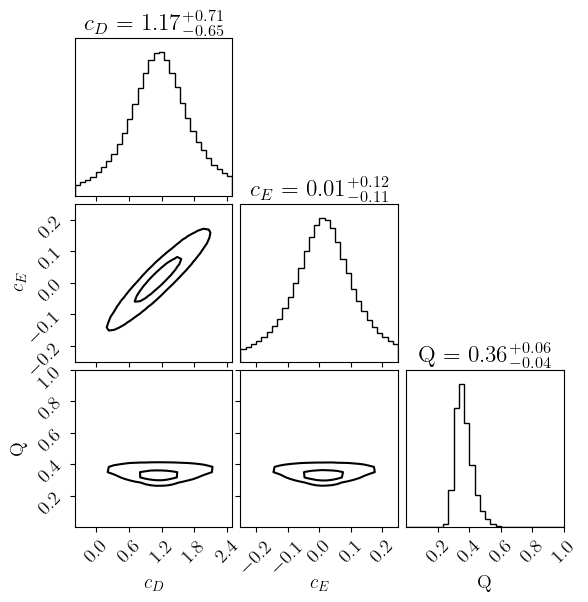

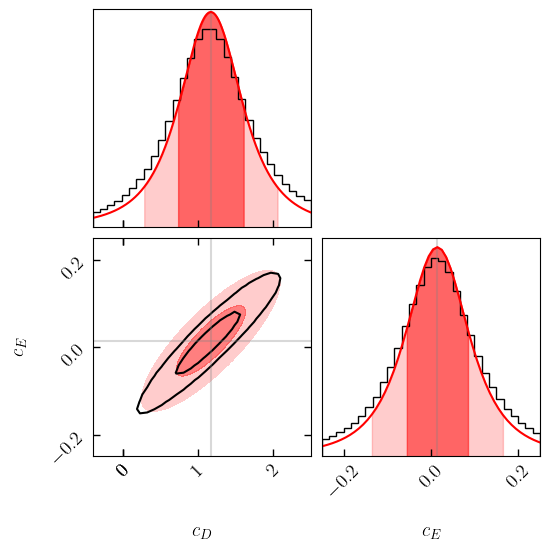

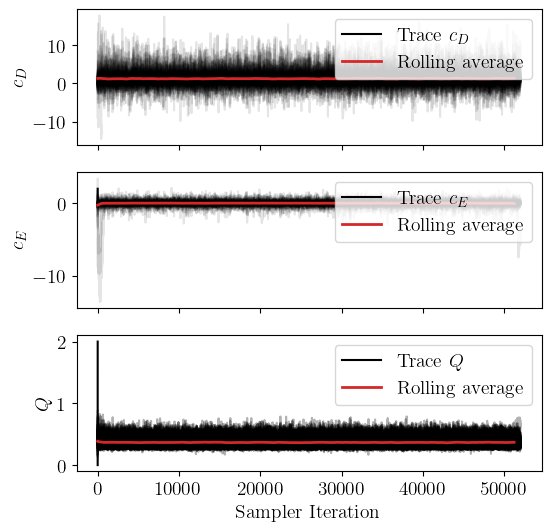

In [46]:
# ---------------------- Analysis of the MCMC samples ----------------------- #  



def fit_samples(samples):
    df_cD, loc_cD, _ = stats.t.fit(samples[:, 0])
    df_cE, loc_cE, _ = stats.t.fit(samples[:, 1])
    df = (df_cD + df_cE) / 2
    loc = [loc_cD, loc_cE]

    t_cov = np.cov(samples[:, :2].T)
    shape = t_cov * (df - 2) / df

    mv_t_pdf = stats.multivariate_t(df=df, loc=loc, shape=shape)

    x = np.linspace(-5, 5, 1000)
    pdf_cD = stats.t.pdf(x, df, loc[0], np.sqrt(shape[0, 0]))
    pdf_cE = stats.t.pdf(x, df, loc[1], np.sqrt(shape[1, 1]))

    pdf_cD_1sigma = np.sum(pdf_cD[(x >= loc[0] - np.sqrt(shape[0, 0])) & (x <= loc[0] + np.sqrt(shape[0, 0]))])
    pdf_cE_1sigma = np.sum(pdf_cE[(x >= loc[1] - np.sqrt(shape[1, 1])) & (x <= loc[1] + np.sqrt(shape[1, 1]))])
    cred_1sigma = [pdf_cD_1sigma / np.sum(pdf_cD), pdf_cE_1sigma / np.sum(pdf_cE)]

    pdf_cD_2sigma = np.sum(pdf_cD[(x >= loc[0] - 2*np.sqrt(shape[0, 0])) & (x <= loc[0] + 2*np.sqrt(shape[0, 0]))])
    pdf_cE_2sigma = np.sum(pdf_cE[(x >= loc[1] - 2*np.sqrt(shape[1, 1])) & (x <= loc[1] + 2*np.sqrt(shape[1, 1]))])
    cred_2sigma = [pdf_cD_2sigma / np.sum(pdf_cD), pdf_cE_2sigma / np.sum(pdf_cE)]

    return df, loc, shape, mv_t_pdf, cred_1sigma, cred_2sigma

def corner_contourf(contour_ax, flat_samples, mv_pdf, mu_cD, mu_cE, sigma_cD, sigma_cE):

    x = np.linspace(-5, 5, 1000)
    y = np.linspace(-5, 5, 1000)    
    x_eval, y_eval = np.meshgrid(x, y)

    pos = np.dstack((x_eval, y_eval))
    pdf_values = mv_pdf.pdf(pos)

    pdf_1sigma = mv_pdf.pdf((mu_cD-sigma_cD, mu_cE-sigma_cE))
    pdf_2sigma = mv_pdf.pdf((mu_cD-2*sigma_cD, mu_cE-2*sigma_cE))
    mv_pdf_max = np.max(mv_pdf.pdf(pos))
    levels = [pdf_2sigma, pdf_1sigma, mv_pdf_max]

    contourf_plot = contour_ax.contourf(x, y, mv_pdf.pdf(pos), levels=levels, 
                                colors=['r', 'r'], alpha=[0.2, 0.5])
    #contour_ax.contour(x, y, mv_pdf.pdf(pos), levels=[pdf_95, pdf_68], colors='k')

    xticks_cD, xticks_cE = [-0, 0., 1, 2], [-0.2, 0., 0.2]

    contour_ax.set_xlim(-0.4, 2.5)
    contour_ax.set_ylim(-0.25, 0.25)
    contour_ax.set_xticks(xticks_cD)
    contour_ax.set_yticks(xticks_cE)
    contour_ax.yaxis.set_ticks_position('both')
    contour_ax.xaxis.set_ticks_position('both')
    contour_ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')

    contour_ax.axvline(mu_cD, color='gray', linestyle='-', alpha=0.3)
    contour_ax.axhline(mu_cE, color='gray', linestyle='-', alpha=0.3)

    return xticks_cD, xticks_cE, contour_ax.get_xlim()

def plot_fit(ax, df_fit, loc_fit, scale_fit, cred_region):
    
    def fill(cred_region, alpha):
        lower = stats.t.ppf(1-(1+cred_region)/2, df_fit, loc_fit, scale_fit)
        upper = stats.t.ppf((1+cred_region)/2, df_fit, loc_fit, scale_fit)
        ax.fill_between(x, pdf, where=((x >= lower) & (x <= upper)), 
                    color='r', alpha=alpha)

    # Each 'poly' is a Polygon object; we can extract the vertices
    verts = ax.patches[0].get_xy()

    # The x-values represent the bin edges, y-values represent the heights
    bin_left_edges = verts[:, 0]
    bin_heights = verts[:, 1]
    bin_width = np.diff(bin_left_edges)[1]

    # Total histogram area
    area = np.sum(bin_width/2 * bin_heights)

    # Generate the t-distribution PDF using the fitted parameters
    x = np.linspace(-5, 5, 1000)
    pdf = stats.t.pdf(x, df_fit, loc_fit, scale_fit) * area

    # Plot the t-distribution PDF over the histogram
    ax.axvline(loc_fit, color='gray', linestyle='-', alpha=0.3)
    ax.plot(x, pdf, 'r')
    
    fill(cred_region[1], 0.2)
    fill(cred_region[0], 0.5)

# Retrieve the samples from the MCMC chain
flat_samples_3d = sampler_3d.get_chain(discard=2000, thin=1, flat=True)

fig = corner.corner(flat_samples_3d, labels=[r"$c_D$", r"$c_E$", r"Q"], color='k',
                     show_titles=True, bins=30, plot_contours=True, plot_datapoints=False, 
                     plot_density=False, levels=[0.3, 0.72], range=[(-0.4, 2.5), (-0.25, 0.25), (0, 1)])
fig.set_size_inches(6, 6)
print(flat_samples_3d.shape)
print('Number of samples: ', flat_samples_3d.shape[0])
# Reshape the flattened samples to a 2D array
samples_3d = flat_samples_3d.reshape(-1, 3)

# Plot the corner plot with the 1 and 2-sigma contours, only for cD and cE
fig_onlyC = corner.corner(samples_3d[:,:2], labels=[r"$c_D$", r"$c_E$"], color='k',
                        show_titles=False, bins=30, plot_contours=True, plot_datapoints=False, 
                        plot_density=False, levels=[0.3, 0.72],
                        range=[(-0.4, 2.5), (-0.25, 0.25)])
fig_onlyC.set_size_inches(6, 6)

df_fit, loc_fit, scale_fit, mv_t_pdf, cred_1sigma, cred_2sigma = fit_samples(samples_3d)

data = {'Mean': loc_fit, 'Sigma': np.sqrt(np.diag(scale_fit)), '1-sigma': cred_1sigma, '2-sigma': cred_2sigma}
df = pd.DataFrame(data, index=['cD', 'cE'])
print('Fitted parameters for the error model:')
display(df)

contour_ax = fig_onlyC.get_axes()[2]
xticks_cD, xticks_cE, xlim = corner_contourf(contour_ax, flat_samples_3d, mv_t_pdf, loc_fit[0], loc_fit[1], np.sqrt(np.diag(scale_fit))[0], np.sqrt(np.diag(scale_fit))[1])

for i, ax in enumerate(fig_onlyC.get_axes()):
    ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
    if i == 0:
        ax.set_xticks(xticks_cD)
        ax.set_xlim(xlim[0], xlim[1])
        cred_region = [cred_1sigma[0], cred_2sigma[0]]
        plot_fit(ax, df_fit, loc_fit[0], np.sqrt(np.diag(scale_fit))[0], cred_region)
    elif i == 3:
        ax.set_xticks(xticks_cE)
        cred_region = [cred_1sigma[1], cred_2sigma[1]]
        plot_fit(ax, df_fit, loc_fit[1], np.sqrt(np.diag(scale_fit))[1], cred_region)

trace_plotter(sampler_3d, iterations=70000, ndim=3,save=True,sampler_idx='Q')
t_test(samples_3d)

fig.savefig('Q-plot.pdf',bbox_inches = 'tight')
fig_onlyC.savefig('C-plot.pdf',bbox_inches = 'tight')
plt.show()


In [44]:
# Retrieve the samples from the MCMC chain
cD_t = samples_3d[:,0]
cE_t = samples_3d[:,1]
#Q = samples[:,2]

# Compute the predictive distributions for the observables
E4He_t, Rp4He_t, _, _, E3H_t, _, fT3H_t = vfewnucleonEmulator(cD_t, cE_t)
obs_values = np.array([E3H_t, E4He_t, Rp4He_t, fT3H_t])

3400.8773105907967 7.297154357069136 2.287635801187098 492340.873624417
0.13269184664859016 0.6908369460884547 0.008615065280155373 29.648615183708714
[1.33666600e-01 6.98885287e-01 1.76427220e-02 2.96481299e+01]
[1.33665521e-01 6.98879648e-01 1.76425797e-02 2.96478907e+01]


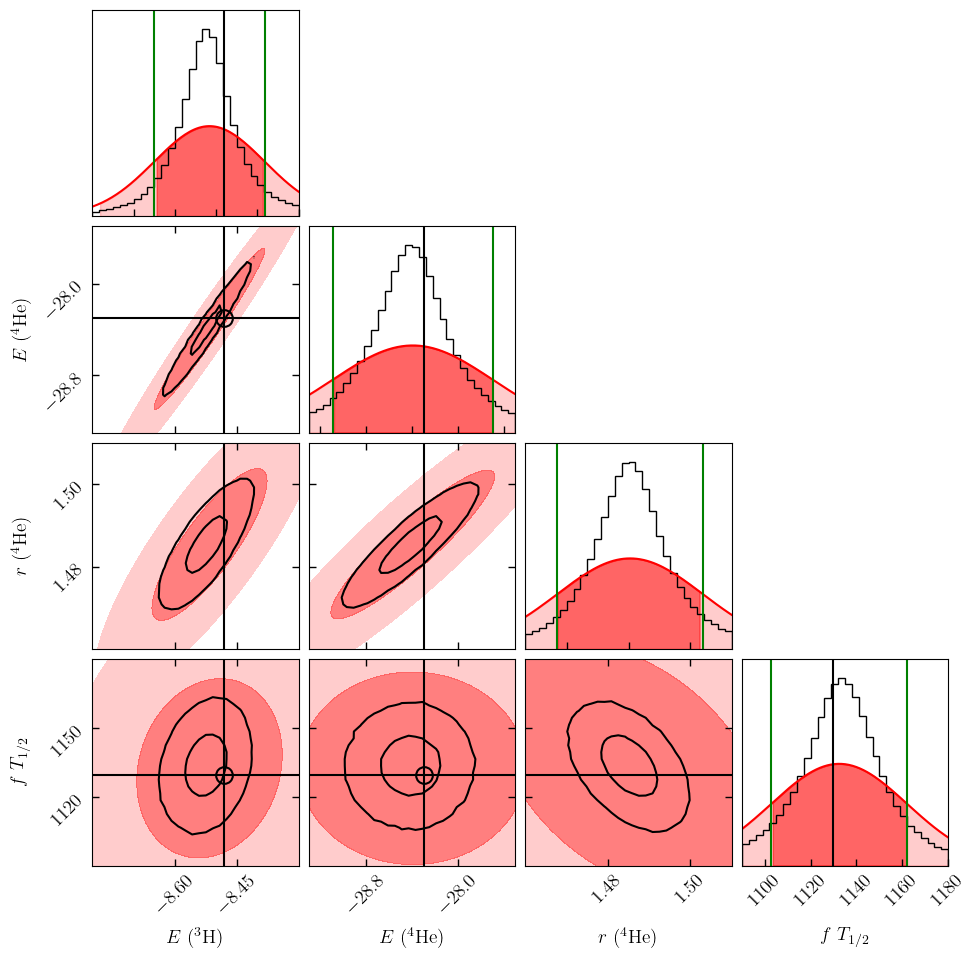

In [45]:
# -------- Functions used to visualize the predictive distributions --------- #
def fit_samples(samples):
    df_E3H, loc_E3H, sigma1 = stats.t.fit(samples[:, 0])
    df_E4He, loc_E4He, sigma2 = stats.t.fit(samples[:, 1])
    df_Rp4He, loc_Rp4He, sigma3 = stats.t.fit(samples[:, 2])
    df_fT3H, loc_fT3H, sigma4 = stats.t.fit(samples[:, 3])
    print(df_E3H, df_E4He, df_Rp4He, df_fT3H)
    print(sigma1, sigma2, sigma3, sigma4)

    df = (df_E3H + df_E4He + df_Rp4He + df_fT3H) / 4
    # df = 2.38
    loc = [loc_E3H, loc_E4He, loc_Rp4He, loc_fT3H]

    t_cov = np.cov(samples[:, :].T)
    print(np.sqrt(np.diag(t_cov)))
    shape = t_cov * (df - 2) / df
    print(np.sqrt(np.diag(shape)))

    mv_t_pdf_obs = stats.multivariate_t(df=df, loc=loc, shape=shape)

    x_E3H = np.linspace(samples[:,0].min(), samples[:,0].max(), 1000)
    x_E4He = np.linspace(samples[:,1].min(), samples[:,1].max(), 1000)
    x_Rp4He = np.linspace(samples[:,2].min(), samples[:,2].max(), 1000)
    x_fT3H = np.linspace(samples[:,3].min(), samples[:,3].max(), 1000)

    pdf_E3H = stats.t.pdf(x_E3H, df, loc[0], np.sqrt(shape[0, 0]))
    pdf_E4He = stats.t.pdf(x_E4He, df, loc[1], np.sqrt(shape[1, 1]))
    pdf_Rp4He = stats.t.pdf(x_Rp4He, df, loc[2], np.sqrt(shape[2, 2]))
    pdf_fT3H = stats.t.pdf(x_fT3H, df, loc[3], np.sqrt(shape[3, 3]))

    pdf_E3H_1sigma = np.sum(pdf_E3H[(x_E3H >= loc[0] - np.sqrt(shape[0, 0])) & (x_E3H <= loc[0] + np.sqrt(shape[0, 0]))])
    pdf_E4He_1sigma = np.sum(pdf_E4He[(x_E4He >= loc[1] - np.sqrt(shape[1, 1])) & (x_E4He <= loc[1] + np.sqrt(shape[1, 1]))])
    pdf_Rp4He_1sigma = np.sum(pdf_Rp4He[(x_Rp4He >= loc[2] - np.sqrt(shape[2, 2])) & (x_Rp4He <= loc[2] + np.sqrt(shape[2, 2]))])
    pdf_fT3H_1sigma = np.sum(pdf_fT3H[(x_fT3H >= loc[3] - np.sqrt(shape[3, 3])) & (x_fT3H <= loc[3] + np.sqrt(shape[3, 3]))])
    cred_1sigma = [pdf_E3H_1sigma / np.sum(pdf_E3H), pdf_E4He_1sigma / np.sum(pdf_E4He), 
                   pdf_Rp4He_1sigma / np.sum(pdf_Rp4He), pdf_fT3H_1sigma / np.sum(pdf_fT3H)]

    pdf_E3H_2sigma = np.sum(pdf_E3H[(x_E3H >= loc[0] - 2*np.sqrt(shape[0, 0])) & (x_E3H <= loc[0] + 2*np.sqrt(shape[0, 0]))])
    pdf_E4He_2sigma = np.sum(pdf_E4He[(x_E4He >= loc[1] - 2*np.sqrt(shape[1, 1])) & (x_E4He <= loc[1] + 2*np.sqrt(shape[1, 1]))])
    pdf_Rp4He_2sigma = np.sum(pdf_Rp4He[(x_Rp4He >= loc[2] - 2*np.sqrt(shape[2, 2])) & (x_Rp4He <= loc[2] + 2*np.sqrt(shape[2, 2]))])
    pdf_fT3H_2sigma = np.sum(pdf_fT3H[(x_fT3H >= loc[3] - 2*np.sqrt(shape[3, 3])) & (x_fT3H <= loc[3] + 2*np.sqrt(shape[3, 3]))])
    cred_2sigma = [pdf_E3H_2sigma / np.sum(pdf_E3H), pdf_E4He_2sigma / np.sum(pdf_E4He), 
                   pdf_Rp4He_2sigma / np.sum(pdf_Rp4He), pdf_fT3H_2sigma / np.sum(pdf_fT3H)]
     
    # print('shape',shape)
    # print('error',np.sqrt(np.diag(shape)))
    # print('\n sig1',sigma1, sigma2,sigma3,sigma4,'\n')
    # print('cred_1sig',cred_1sigma)
    # print('cred_2sig',cred_2sigma,'\n')

    return df, loc, shape, mv_t_pdf_obs, cred_1sigma, cred_2sigma

def plot_fit(ax, preds, df_fit, loc_fit, scale_fit, cred_region, var_idx):
        
    def fill(cred_region, alpha):
        lower = stats.t.ppf(1-(1+cred_region)/2, df_fit, loc_fit, scale_fit)
        upper = stats.t.ppf((1+cred_region)/2, df_fit, loc_fit, scale_fit)
        ax.fill_between(x, pdf, where=((x >= lower) & (x <= upper)), 
                    color='r', alpha=alpha)

    ### Each 'poly' is a Polygon object; we can extract the vertices
    verts = ax.patches[0].get_xy()

    ### The x-values represent the bin edges, y-values represent the heights
    bin_left_edges = verts[:, 0]
    bin_heights = verts[:, 1]
    bin_width = np.diff(bin_left_edges)[1]

    ### Total histogram area
    area = np.sum(bin_width/2 * bin_heights)

    ### Generate the t-distribution PDF using the fitted parameters
    x = np.linspace(preds.min(), preds.max(), 1000)
    pdf = stats.t.pdf(x, df_fit, loc_fit, scale_fit) * area
    ### Plot the t-distribution PDF over the histogram
    ax.plot(x, pdf, 'r')
    ax.axvline(x=truths[var_idx], color='k')
    ax.axvline(x=loc_fit-scale_fit, color='g')
    ax.axvline(x=loc_fit+scale_fit, color='g')
    
    fill(cred_region[1], 0.2)
    fill(cred_region[0], 0.5)
    
def corner_contour(contour_ax, mv_pdf, mu, sigma, df_fit, var_idx):
    """
    Plot contours on the given axis for the 2D marginal distribution 
    of the multivariate normal distribution.
    
    contour_ax: Axis to plot on
    flat_samples: MCMC samples (for plotting points, optional)
    mv_pdf: multivariate pdf (e.g., from scipy.stats.multivariate_normal)
    mu: Mean of the multivariate normal distribution
    sigma: Covariance of the multivariate normal distribution
    var_idx: Indices of the two variables to plot (for 2D marginalization)
    """

    # Extract the relevant variables (2D marginal distribution)
    mu_2d = np.array([mu[idx] for idx in var_idx])  # Mean for the two selected variables
    cov_2d = sigma[np.ix_(var_idx, var_idx)]  # Covariance for the selected variables

    # Define the multivariate normal for the 2D marginal
    mv_pdf_2d = stats.multivariate_t(loc=mu_2d, shape=cov_2d, df=df_fit)

    # Create a grid of points over which to evaluate the pdf
    x_min, x_max = contour_ax.get_xlim()
    y_min, y_max = contour_ax.get_ylim()
    x = np.linspace(x_min, x_max, 1000)
    y = np.linspace(y_min, y_max, 1000)
    x_eval, y_eval = np.meshgrid(x, y)
    pos = np.dstack((x_eval, y_eval))

    # Evaluate the 2D pdf at the grid points
    pdf_values = mv_pdf_2d.pdf(pos)
    
    pdf_1sigma = mv_pdf_2d.pdf((mu_2d[0]-np.sqrt(cov_2d[0, 0]), mu_2d[1]-np.sqrt(cov_2d[1, 1])))
    pdf_2sigma = mv_pdf_2d.pdf((mu_2d[0]-2*np.sqrt(cov_2d[0, 0]), mu_2d[1]-2*np.sqrt(cov_2d[1, 1])))
    mv_pdf_max = np.max(mv_pdf_2d.pdf(pos))
    levels = [pdf_2sigma, pdf_1sigma, mv_pdf_max]

    contour_ax.contourf(x, y, pdf_values, levels=levels, 
                        colors=['r', 'r'], alpha=[0.2, 0.5])
    
    contour_ax.axvline(x=truths[var_idx[0]], color='black')
    contour_ax.axhline(y=truths[var_idx[1]], color='black')
    contour_ax.plot(truths[var_idx[0]], truths[var_idx[1]], 'ko', mfc='none', ms=12, mew=1.5)

    contour_ax.set_xticks(ticks[var_idx[0]])
    contour_ax.set_yticks(ticks[var_idx[1]])
    # contour_ax.contour(x, y, pdf_values, levels=[test_95, test_68], colors='k')

# --------- Compute the predictive distributions of the observables --------- #
truths = [y_E3H, y_E4He, y_Rp4He, y_fT3H]
#area = [25000, 77000, 3000, 10000000]

# --- Plotting the corner plot with the posterior predictive distribution --- #   
fig = corner.corner(obs_values.T, labels=[r"$E$ ($^3$H)", r"$E$ ($^4$He)", r"$r$ ($^4$He)", r"$f$ $T_{1/2}$"], color='k',
                    show_titles=False, bins=30, plot_contours=True, plot_datapoints=False, 
                    plot_density=False, levels=[0.3, 0.72], range=[(-8.8, -8.3), (-29.3, -27.5), (1.46, 1.510), (1090, 1180)])
fig.set_size_inches(10, 10)

# ----------------- Customize the figure and plot the fits ------------------ #
# Define the indices for the diagonal and contour plots
diag_indices = [0, 5, 10, 15]
contour_indices = [4, 8, 9, 12, 13, 14]
# Define the indices for the variables in the 2D marginal distribution,
var_indices = [(0, 1), (0, 2), (1, 2), (0, 3), (1, 3), (2, 3)]
ticks = [(-8.6, -8.45), (-28.8, -28), (1.48, 1.50), (1120, 1150)]

# Fit the predictive distributions to a multivariate t distribution
df_fit, loc_fit, shape_fit, mv_t_pdf_obs, cred_1sigma, cred_2sigma = fit_samples(obs_values.T)

for i, ax in enumerate(fig.get_axes()):
    ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
    if i in diag_indices:
        preds = obs_values.T[:, diag_indices.index(i)]
        cred_region = [cred_1sigma[diag_indices.index(i)], cred_2sigma[diag_indices.index(i)]]
        plot_fit(ax, preds, df_fit, loc_fit[diag_indices.index(i)], np.sqrt(np.diag(shape_fit))[diag_indices.index(i)], cred_region, diag_indices.index(i))
    elif i in contour_indices:
        ax.yaxis.set_ticks_position('both')
        ax.xaxis.set_ticks_position('both')
        corner_contour(ax, mv_t_pdf_obs, loc_fit, shape_fit, df_fit, var_idx=var_indices[contour_indices.index(i)])
